# EX_17 난 스케치를 할 테니 너는 채색을 하거라

## 목표:  Segmentation map으로 도로 이미지 만들기

### lubric

1. pix2pix 모델 학습을 위한 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.
2. U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.
3. 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

### 학습 목표

- 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해합니다.
- cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용합니다.
- CNN 기반의 모델을 구현하는데 자신감을 갖습니다.

### 학습 전제

Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적으로 알고 있어야 합니다.
신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.
CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.
Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해할 수 있어야 합니다.
(중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해 보려는 의지가 필요합니다.

### 🚩keyword

✔ Gan, Generator, Encoder, Decoder, U-Net, skip connection, Discriminator, PatchGAN

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [23]:
import tensorflow as tf

import os
import time
import cv2
import numpy as np

from glob import glob
from matplotlib import pyplot as plt
import matplotlib.image as image
from IPython import display

In [24]:
# 학습 데이터 샘플 수
import os

data_path = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_17/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [25]:
# 검증 데이터 샘플 수
import os

data_path2 = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_17/conditional_generation/data/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path2)))

number of val examples : 5


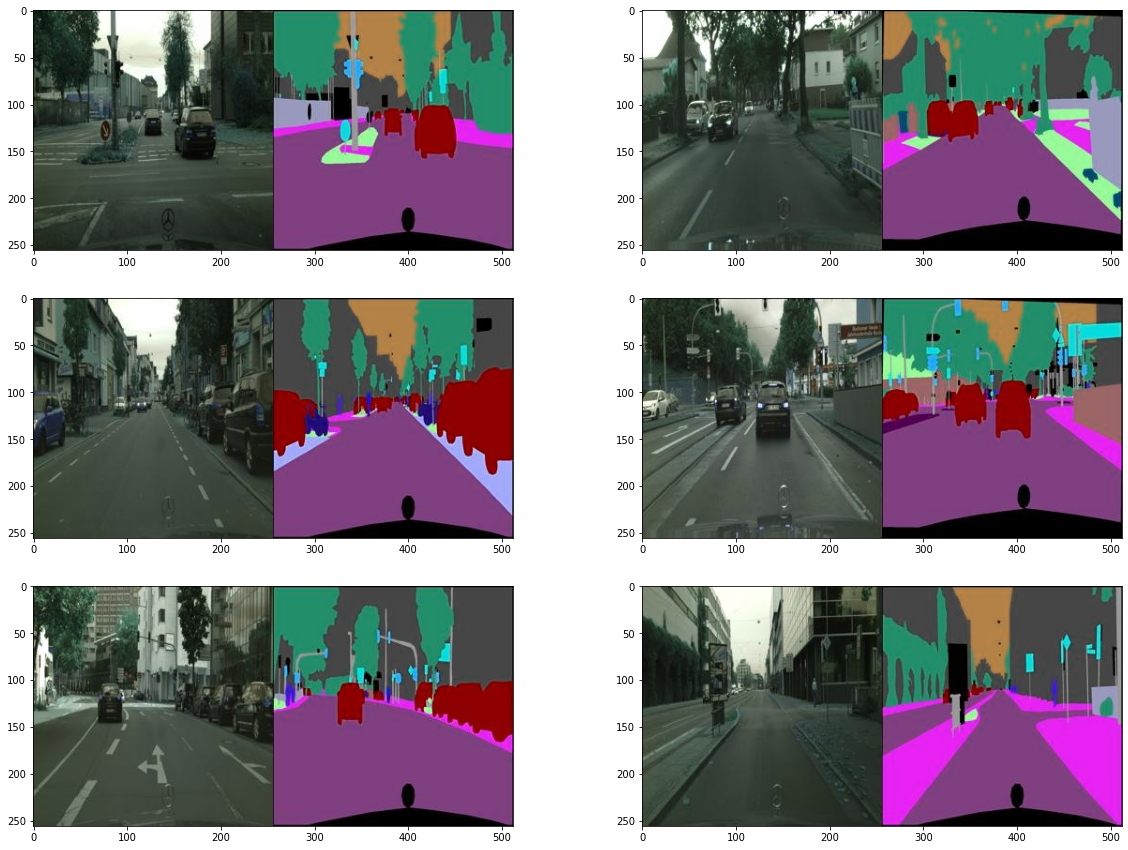

In [26]:
# 데이터셋 시각화

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [27]:
# 이미지 크기 확인

f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


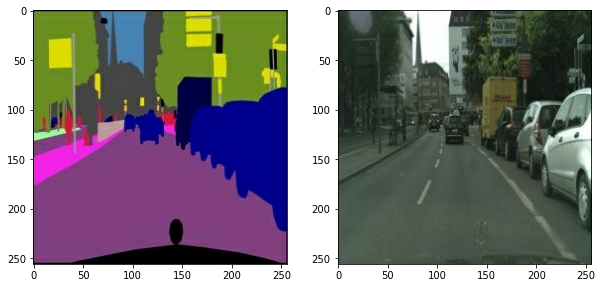

In [28]:
# (256, 512, 3)으로 확인
# 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

In [29]:
# 학습에 사용할 수 있는 데이터의 수는 약 1000개뿐
# 여러 augmentation 방법을 적용

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # 두 이미지가 채널 축으로 연결
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT") # 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6]) # (256,256,6) 크기를 가진 이미지를 임의로 자르기
    
    out = image.random_flip_left_right(out) # 50% 확률로 가로로 뒤집기
    out = image.random_flip_up_down(out) # 50% 확률로 세로로 뒤집기
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree) # 50% 확률로 회전
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


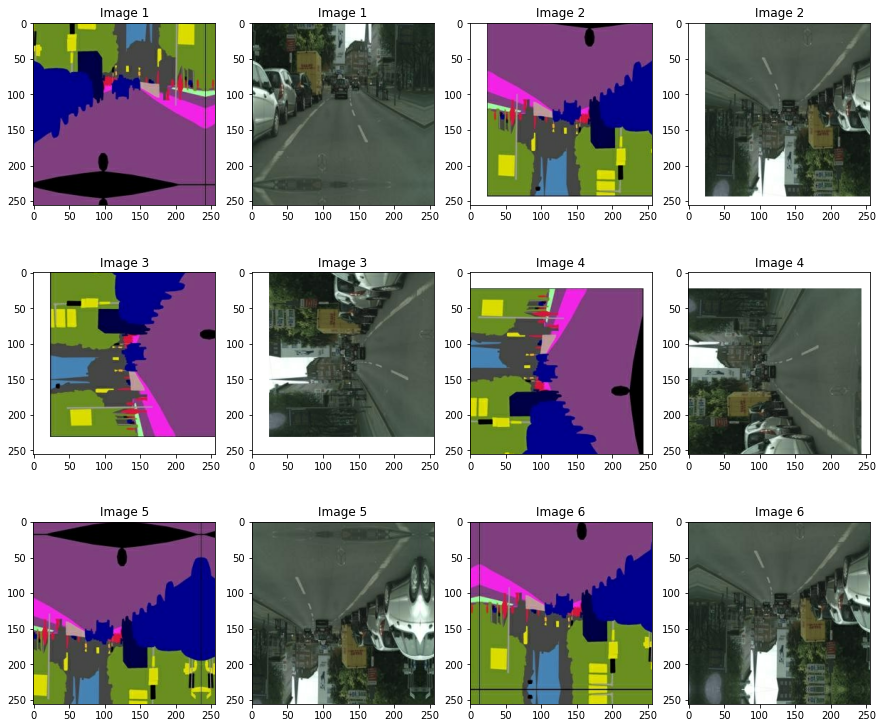

In [30]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

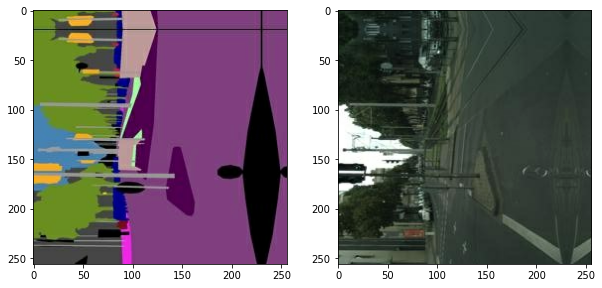

In [31]:
# 하나의 이미지만 시각화하여 확인

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### U-Net Generator

In [32]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [33]:
# skip connection이 있는 U-Net Generator를 사용

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512] # 필터의 크기가 커졌다가 
        decode_filters = [512,512,512,512,256,128,64] # 작아진다
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니므로 뺀다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): # Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [34]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_24 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_25 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_24[0][0]            
__________________________________________________________________________________________________
encode_block_26 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_25[0][0]            
____________________________________________________________________________________________

✔ 필터의 갯수는 커졌다 작아지는 반면 채널의 갯수는 작아졌다가 커지는 걸 알 수 있다.

✔  __init__() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행.
이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다. 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

### Discriminator 

In [35]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

In [36]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # for loop로 간편하게 블록 만들기
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [37]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_24 (Concatenate)    (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_24[0][0]       

✔ input layer 2개, in/unknown을 받아 concat -> disc block 통과 -> 논문 그대로 C64-128-256-512 -> 마지막 블럭 -> 1차원 출력을 위한 block 최종 출력 크기 (30,30,1)

✔ 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다.

### 모델 학습 및 테스트

In [38]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [39]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [40]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


✔ Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력 존재. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산.

✔ Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력 존재, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교.

#### 1) epochs = 30 

In [19]:
EPOCHS = 30

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:1.1626                     
L1_loss:0.1880                     
Discriminator_loss:1.3130

EPOCH[1] - STEP[200]                     
Generator_loss:1.9000                     
L1_loss:0.1665                     
Discriminator_loss:0.8924

EPOCH[2] - STEP[100]                     
Generator_loss:1.1778                     
L1_loss:0.1660                     
Discriminator_loss:0.6812

EPOCH[2] - STEP[200]                     
Generator_loss:0.9882                     
L1_loss:0.1863                     
Discriminator_loss:0.8109

EPOCH[3] - STEP[100]                     
Generator_loss:1.0192                     
L1_loss:0.1979                     
Discriminator_loss:1.7757

EPOCH[3] - STEP[200]                     
Generator_loss:0.6067                     
L1_loss:0.1920                     
Discriminator_loss:1.2536

EPOCH[4] - STEP[100]                     
Generator_loss:0.3680                     
L1_loss:0.2039             

EPOCH[29] - STEP[100]                     
Generator_loss:2.0029                     
L1_loss:0.2112                     
Discriminator_loss:0.3198

EPOCH[29] - STEP[200]                     
Generator_loss:1.4096                     
L1_loss:0.1828                     
Discriminator_loss:0.4699

EPOCH[30] - STEP[100]                     
Generator_loss:1.0103                     
L1_loss:0.1737                     
Discriminator_loss:0.7358

EPOCH[30] - STEP[200]                     
Generator_loss:0.5768                     
L1_loss:0.2126                     
Discriminator_loss:0.9858



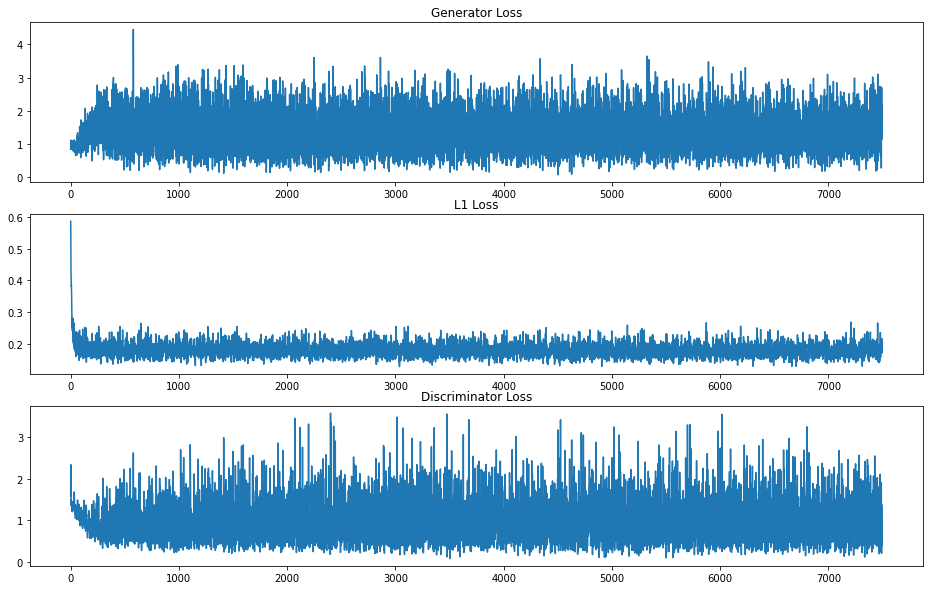

In [20]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

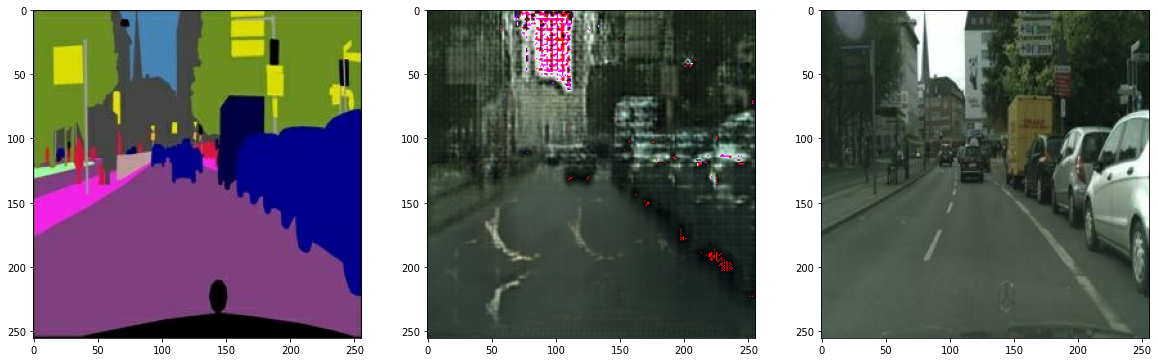

In [21]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

#### 2) epochs = 50 

In [41]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 100 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[100]                     
Generator_loss:0.7278                     
L1_loss:0.1835                     
Discriminator_loss:1.1530

EPOCH[1] - STEP[200]                     
Generator_loss:1.8029                     
L1_loss:0.1845                     
Discriminator_loss:0.4668

EPOCH[2] - STEP[100]                     
Generator_loss:1.1006                     
L1_loss:0.1931                     
Discriminator_loss:0.7579

EPOCH[2] - STEP[200]                     
Generator_loss:1.9752                     
L1_loss:0.1713                     
Discriminator_loss:0.7242

EPOCH[3] - STEP[100]                     
Generator_loss:0.2640                     
L1_loss:0.1855                     
Discriminator_loss:1.9172

EPOCH[3] - STEP[200]                     
Generator_loss:0.4792                     
L1_loss:0.1664                     
Discriminator_loss:1.7856

EPOCH[4] - STEP[100]                     
Generator_loss:0.7170                     
L1_loss:0.1809             

EPOCH[29] - STEP[100]                     
Generator_loss:1.2582                     
L1_loss:0.1664                     
Discriminator_loss:0.6552

EPOCH[29] - STEP[200]                     
Generator_loss:1.4215                     
L1_loss:0.1679                     
Discriminator_loss:0.3472

EPOCH[30] - STEP[100]                     
Generator_loss:0.8989                     
L1_loss:0.1550                     
Discriminator_loss:1.0046

EPOCH[30] - STEP[200]                     
Generator_loss:1.8842                     
L1_loss:0.2057                     
Discriminator_loss:0.2260

EPOCH[31] - STEP[100]                     
Generator_loss:0.5436                     
L1_loss:0.1585                     
Discriminator_loss:1.8220

EPOCH[31] - STEP[200]                     
Generator_loss:0.7442                     
L1_loss:0.1706                     
Discriminator_loss:0.9391

EPOCH[32] - STEP[100]                     
Generator_loss:2.2968                     
L1_loss:0.1601      

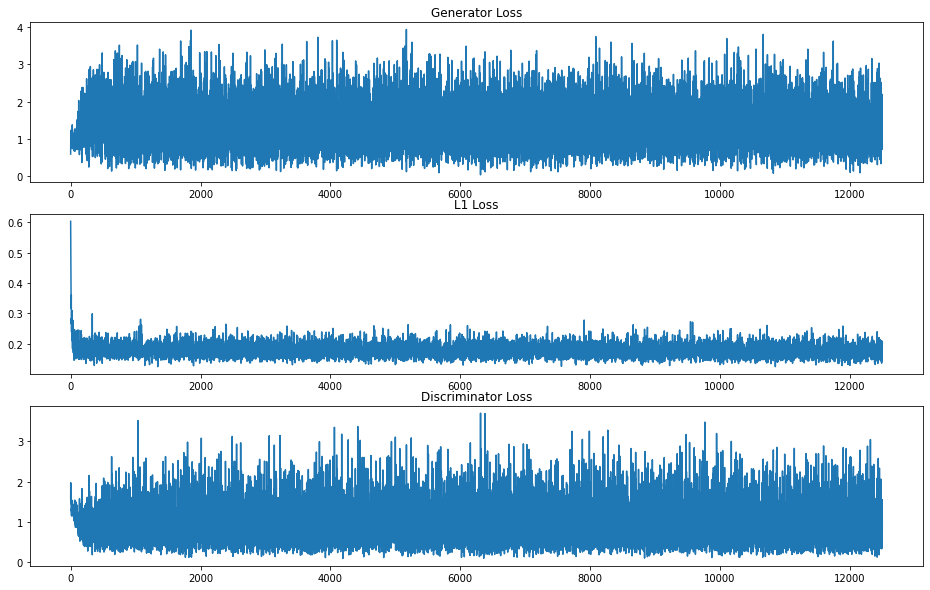

In [42]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

Text(0.5, 1.0, 'Ground Truth')

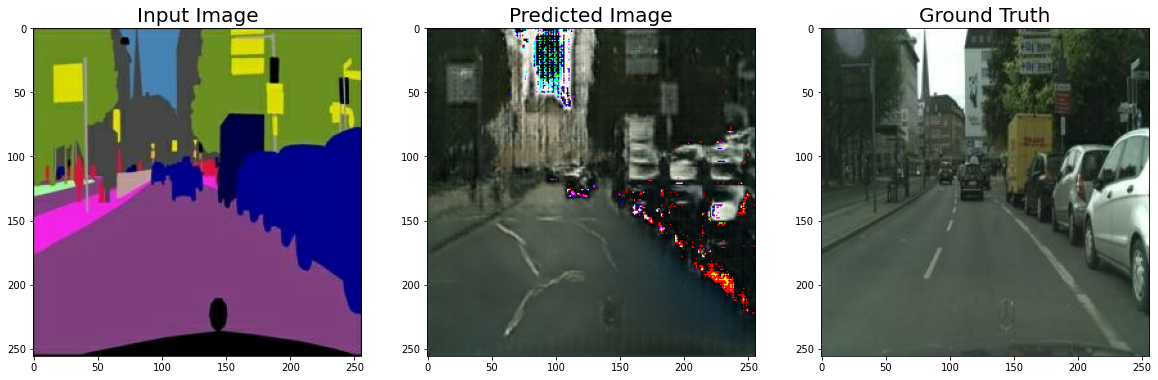

In [46]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)); plt.title('Input Image', fontsize=20)
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
plt.subplot(1,3,3); plt.imshow(denormalize(colored)); plt.title('Ground Truth', fontsize=20)

#### trial and error

노드 설명이 자세해서 딱히 손을 댈 곳이 없었다. 마침 제일 친근한 GAN이 마지막 노드여서 더 그런것도 있고. Generate랑 discriminator의 개념은 언제 봐도 재밌다. epochs 기본 100은 돌려야겠지만 시간관계상 30,50만 돌려봤는데 약간의 차이가 있어서 다행이었고 마침 GD의 augmentation이 다음 공부여서 공부하고 나중에 다시 해보면 좋을 것 같다. 마지막 노드인데 신경을 많이 못써준 것 같아 미안! 